import


In [1]:
import investpy
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import matplotlib.pyplot as plt

In [4]:
CK = input("Nhập mã chứng khoán")

dowload data

In [9]:
day = dt.datetime.now().strftime('%d/%m/%Y')
df = investpy.get_stock_historical_data(stock=CK,
                                        country='Vietnam',
                                        from_date='01/01/2018',
                                        to_date=day)
print(df.head())

               Open     High      Low    Close  Volume Currency
Date                                                           
2018-01-02  10100.0  10200.0  10000.0  10200.0    6200      VND
2018-01-04  11600.0  11600.0  11600.0  11600.0     100      VND
2018-01-05  13300.0  13300.0  13300.0  13300.0    8584      VND
2018-01-08  13300.0  14800.0  13300.0  14800.0   10100      VND
2018-01-10  14000.0  14000.0  14000.0  14000.0    6615      VND


xử lý data ,và thêm chỉ số cần thiết để phân tích

In [10]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['Close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['Close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['Close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['Close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['Close'].rolling(window=ma_3).std()
df.dropna(inplace=True)

Lưa data ra file csv

In [12]:
df.to_csv(f"{CK}.csv")
print("Done Loading Data")

Done Loading Data


Process Data

In [13]:
pre_day = 30
scala_x = MinMaxScaler(feature_range=(0, 1))
scala_y = MinMaxScaler(feature_range=(0, 1))
cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['Close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))


x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

test_size = 365

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(144, 30, 7) (144, 1) (365, 30, 7) (365, 1)


Build Model

In [15]:
model = Sequential()

model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
model.save(f"{CK}.h5")
print("Done Training Model")

Epoch 1/120
40/40 [==============================] - 6s 20ms/step - loss: 0.0678
Epoch 2/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0483
Epoch 3/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0286
Epoch 4/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0380
Epoch 5/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0303
Epoch 6/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0232
Epoch 7/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0286
Epoch 8/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0176
Epoch 9/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0176
Epoch 10/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0220
Epoch 11/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0155
Epoch 12/120
40/40 [==============================] - 1s 20ms/step - loss: 0.0131
Epoch 13/120
40/40 [=====

Testing

In [16]:
predict_prices = model.predict(x_test)
predict_prices = scala_y.inverse_transform(predict_prices)

12/12 [==============================] - 2s 12ms/step


Ploting the Stat

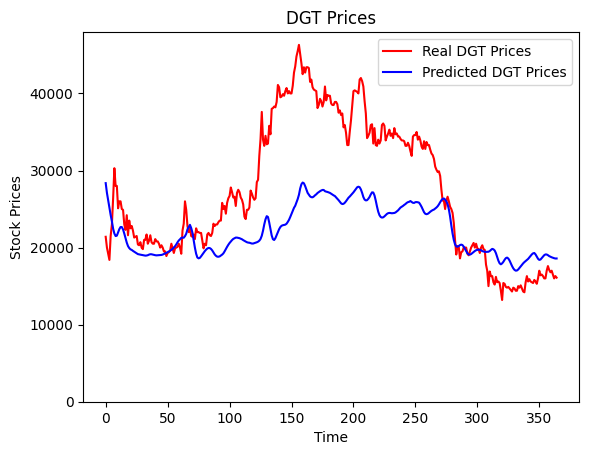

In [18]:
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)

plt.plot(real_price, color="red", label=f"Real {CK} Prices")
plt.plot(predict_prices, color="blue", label=f"Predicted {CK} Prices")
plt.title(f"{CK} Prices")
plt.xlabel("Time")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

 Đường màu xanh là đường mà chúng ta dự đoán 
 Đường màu đỏ là đường giá thực , mình đưa vào để kiểm tra giá dự đoán có sát với thực tế không
 Nên đường dự đoán này là dự đoán 365 ngày trước ,nếu muốn dự đoán tương lai các bạn chỉnh test_size = 0 
 Như các bạn thấy thì mô hình dự đoán đi khá sát với thực tế

In [19]:
x_predict = df[len(df)-pre_day:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scala_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))
prediction = model.predict(x_predict)
prediction = scala_y.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 18ms/step
[[18610.855]]
